In [226]:
%pylab inline

import pylab
import numpy as np
import nengo
import nengolib

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [227]:
def f(x):
    return -0.5*(100*x[0])**3 + x[1]

tau = 0.005
dt = 0.00001
T = 0.2

with nengolib.Network() as model:
    stim = nengo.Node(output=nengo.processes.WhiteSignal(T, high=1000))
    
    # NEF principle 3 (nonlinear case)
    x_nef = nengo.Node(size_in=2, output=lambda t, x: x)  # passthrough hack (#805)
    nengo.Connection(x_nef, x_nef[0], function=lambda (x, u): tau*f((x, u)) + x, synapse=tau)
    nengo.Connection(stim, x_nef[1], synapse=None)
    
    # Ideal dynamical system
    x_ideal = nengo.Node(size_in=2, output=lambda t, x: x)  # passthrough hack (#805)
    nengo.Connection(x_ideal, x_ideal[0], function=f, synapse=~nengolib.signal.s)
    nengo.Connection(stim, x_ideal[1], synapse=None)
    
    p_nef = nengo.Probe(x_nef[0], synapse=None)
    p_ideal = nengo.Probe(x_ideal[0], synapse=None)

In [228]:
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T)

Simulation finished in 0:00:02.                                                 


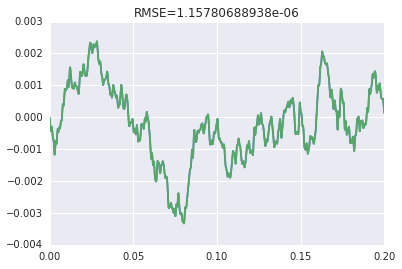

In [229]:
pylab.figure()
pylab.title("RMSE=%s" % (nengo.utils.numpy.rmse(sim.data[p_nef], sim.data[p_ideal])))
pylab.plot(sim.trange(), sim.data[p_nef], label="NEF")
pylab.plot(sim.trange(), sim.data[p_ideal], label="Ideal")
pylab.show()

In [315]:
n_neurons = 1000
tau = 0.005

T = 0.5
dt = 0.001

with nengolib.Network() as model:
    stim = nengo.Node(output=nengo.processes.WhiteSignal(T, high=10, rms=0.2))
    
    x = nengo.Ensemble(n_neurons, 1)
    nengo.Connection(stim, x, synapse=None)
    y = nengo.Node(size_in=1)
    nengo.Connection(x, y, synapse=None, function=lambda x: x**2)
    
    p_stim = nengo.Probe(stim, synapse=None)
    p_x = nengo.Probe(y, synapse=tau)
    
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T)

Simulation finished in 0:00:01.                                                 


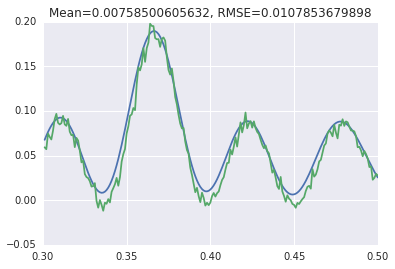

In [316]:
offset = 300
expected = nengo.Lowpass(tau).filt(sim.data[p_stim] ** 2, dt=dt)[offset:]
actual = sim.data[p_x][offset:]
t = sim.trange()[offset:]
    
pylab.figure()
pylab.title("Mean=%s, RMSE=%s" % (np.mean(expected - actual), nengo.utils.numpy.rmse(expected, actual)))
pylab.plot(t, expected)
pylab.plot(t, actual)
pylab.show()    